# Time-lagged autoencoders

For users already familiar with the time-lagged autoencoders interface: The corresponding API docs [TAE](../api/generated/deeptime.decomposition.deep.TAE.rst) and [TVAE](../api/generated/deeptime.decomposition.deep.TVAE.rst).

Time-lagged autoencoders <cite data-footcite="wehmeyer2018timelagged">(Wehmeyer, 2018)</cite> are a type of neural network approach which tries to first compress / encode instantaneous data through a function

$$ E : \mathbb{R}^N \to \mathbb{R}^n, x_t\mapsto E(x_t) $$

with $N \geq n$ and then reconstruct $x_{t+\tau}$ from $E(x_t)$ through a decoder network

$$ D : \mathbb{R}^n \to \mathbb{R}^N, z \mapsto D(z). $$

To this end, the optimization target is defined as the mean-squared error between $x_{ t + \tau }$ and $D(E( x_t ))$.

By this, they differ from classical autoencoders which would try to reconstruct the instantaneous data.

In deeptime, time-lagged autoencoders come in two flavors, analogously to autoencoders and variational autoencoders <cite data-footcite="kingma2013auto">(Kingma, 2013)</cite>.
To get started, we need to import [PyTorch](https://pytorch.org/) as well as deeptime.

In [1]:
import torch

Also, we need to specify how many CPU threads to use and on what kind of device to train the model.

In [2]:
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.set_num_threads(12)

This documentation explains the basic API of time-lagged autoencoders using sqrt-model data. It is a hidden two-state jump process with a two-dimensional observable emission distribution so that the two states cannot be linearly separated.

In [3]:
from deeptime.data import sqrt_model

dtraj, traj = sqrt_model(n_samples=10000)

Here, `dtraj` are the discrete reference states and `traj` is the observable trajectory:

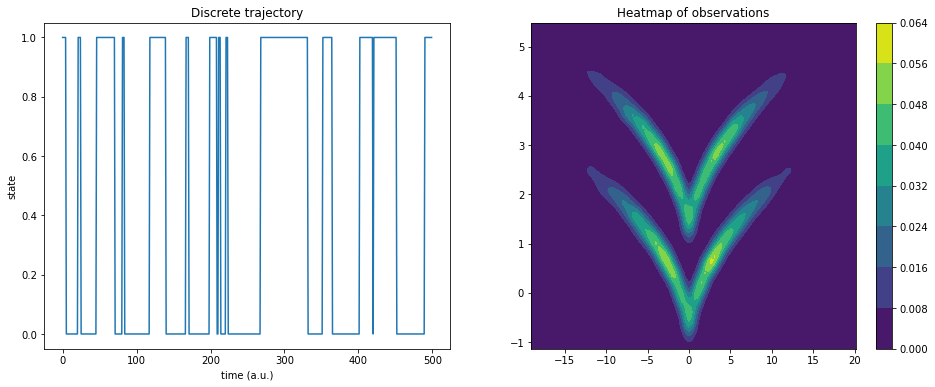

In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

X, Y = np.meshgrid(
    np.linspace(np.min(traj[:, 0]), np.max(traj[:, 0]), 100),
    np.linspace(np.min(traj[:, 1]), np.max(traj[:, 1]), 100),
)
kde_input = np.dstack((X, Y)).reshape(-1, 2)

kernel = stats.gaussian_kde(traj.T, bw_method=.1)
Z = kernel(kde_input.T).reshape(X.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(dtraj[:500])
ax1.set_title('Discrete trajectory')
ax1.set_xlabel('time (a.u.)')
ax1.set_ylabel('state')

cm = ax2.contourf(X, Y, Z)
plt.colorbar(cm, ax=ax2);
ax2.set_title('Heatmap of observations');

To make life downstream a bit easier, we wrap the data into a [time-lagged dataset](../api/generated/deeptime.data.TimeLaggedDataset.rst#deeptime.data.TimeLaggedDataset), perform a train/validation set split, and create PyTorch data loaders:

In [5]:
from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, traj.astype(np.float32))

n_val = int(len(dataset)*.5)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

loader_train = DataLoader(train_data, batch_size=64, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

## Autoencoders

To define an ordinary autoencoder, encoder and decoder torch modules must be provided. To make things easier, deeptime offers the multi-layer preceptron as a building block:

In [6]:
from deeptime.util.torch import MLP

units = [2, 10, 10, 1]
encoder = MLP(units, nonlinearity=torch.nn.ReLU, output_nonlinearity=torch.nn.Sigmoid, 
              initial_batchnorm=False)
decoder = MLP(units[::-1], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)

Now all that is left to do is create a time-lagged autoencoder estimator and fit it on the data loaders.

In [7]:
from deeptime.decomposition.deep import TAE

tae = TAE(encoder, decoder, learning_rate=1e-3)
tae.fit(loader_train, n_epochs=30, validation_loader=loader_val)
tae_model = tae.fetch_model()

The loss can be visualized and it can be seen, that our model does not overfit.

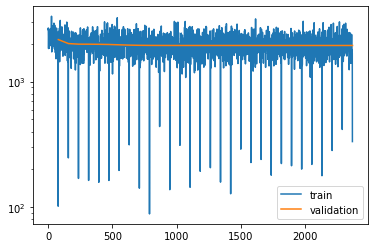

In [8]:
plt.semilogy(*tae.train_losses.T, label='train')
plt.semilogy(*tae.validation_losses.T, label='validation')
plt.legend();

The projection reveals a separation into two states

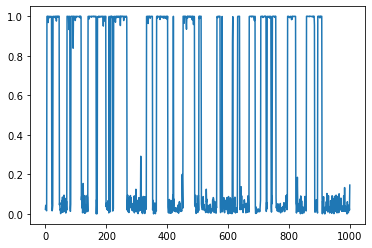

In [9]:
proj = tae_model.transform(traj)
plt.plot(proj[:1000])

Coloring the data points according to the latent code reveals that the model managed to disentangle the sqrt-model:

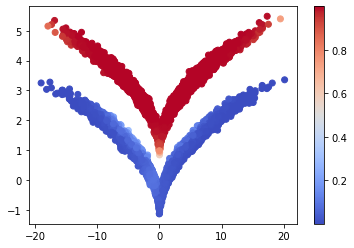

In [10]:
cm = plt.scatter(*traj.T, c=proj, cmap='coolwarm')
plt.colorbar(cm);

## Variational autoencoders

Instead of learning a deterministic forward mapping, in time-lagged variational autoencoders (TVAEs) a input distribution is mapped to a target distribution. To this end, the encoder maps to Gaussians and the decoder transforms the Gaussian distribution to the desired output distribution.

Since Gaussians are parameterized, the encoder maps not to a single latent code but to a mean vector and a log-variance vector, i.e., is expected to produce a tuple of tensors.

Again, deeptime provides a multilayer-perceptron-like architecture that performs this job:

In [11]:
from deeptime.decomposition.deep import TVAEEncoder

encoder = TVAEEncoder([2, 100, 100, 1], nonlinearity=torch.nn.ReLU)
print(encoder)

TVAEEncoder(
  (_sequential): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (_to_mu): Linear(in_features=100, out_features=1, bias=True)
  (_to_logvar): Linear(in_features=100, out_features=1, bias=True)
)


The decoder can be an ordinary MLP as in the autoencoder case.

In [12]:
decoder = MLP([1, 100, 100, 2], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)

Now, the TVAE can be constructed and trained.

In [13]:
from deeptime.decomposition.deep import TVAE

tvae = TVAE(encoder, decoder, learning_rate=1e-2)
tvae.fit(loader_train, n_epochs=30, validation_loader=loader_val)
tvae_model = tvae.fetch_model()

Also here we can have a look at the loss:

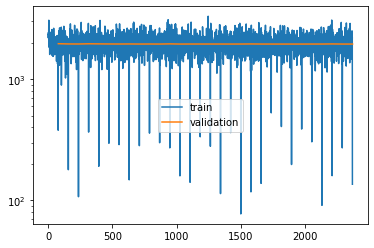

In [14]:
plt.semilogy(*tvae.train_losses.T, label='train')
plt.semilogy(*tvae.validation_losses.T, label='validation')
plt.legend();

And again, the network separates the two distributions.

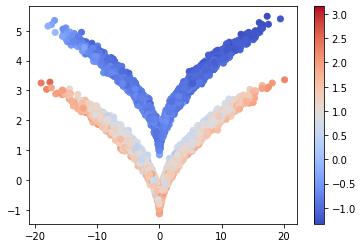

In [15]:
cm = plt.scatter(*traj.T, c=tvae_model.transform(traj), cmap='coolwarm')
plt.colorbar(cm);